<a href="https://colab.research.google.com/github/hmyrcmn/MachinaLearning/blob/main/YoloV8_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# 1. Kaggle API anahtarını yükleyin
from google.colab import files
files.upload()

# 2. API anahtarını taşıyın ve gizli bir şekilde saklayın
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. Veri setini indirin
!kaggle datasets download -d andrewmvd/face-mask-detection

# 4. Veri setini çıkartın
!unzip -q face-mask-detection.zip -d ./face-mask-detection


Saving kaggle.json to kaggle.json
 96% 383M/398M [00:04<00:00, 88.0MB/s]
100% 398M/398M [00:04<00:00, 84.0MB/s]


In [35]:
# I import libraries that I will use.(Kullanacağım kütüphaneleri import ediyorum.)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For preparing (Hazırlık için)
import xml.etree.cElementTree as ET
import glob
import os
import json
import random
import shutil

from PIL import Image, ImageOps

In [36]:
# Tagged data in XML format(Etiketlenmiş verilerin XML formatındaki hali)
with open('/content/face-mask-detection/annotations/maksssksksss0.xml') as f:
    contents = f.read()
    print(contents)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</

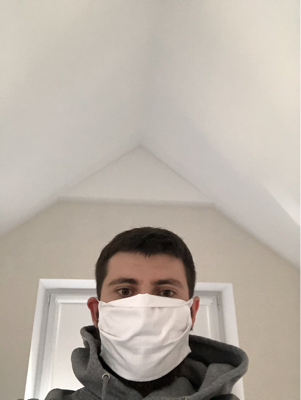

In [37]:
Image.open("/content/face-mask-detection/images/maksssksksss10.png")



Bu kısımda YoloV8 için veri setimizi hazırladım. XML formatında etiketlenen verileri TXT formartına dönüştürdüm. Yolo için Traning etiket verilerini oluşturdum.

In [38]:
# Converting XML format data to TXT format(XML formatındaki verileri TXT formatına dönüştürme)
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h

    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h

    return [x_center, y_center, width, height]

def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center, width, height
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2

    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)

    return [xmin, ymin, xmax, ymax]

classes = ["without_mask", "with_mask", "mask_weared_incorrect"]

input_dir = "/content/face-mask-detection/annotations"
output_dir = "/content/labels"
image_dir = "/content/face-mask-detection/images"


if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

import glob

files = glob.glob(os.path.join(input_dir, "*.xml"))
for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    if not os.path.exists(os.path.join(image_dir, f"{filename}.png")):
        print(f"{filename} image does not exist!")
        continue

    result = []

    # Parse the content of the xml file(Xml dosyasının içeriğini ayrıştırın)
    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall("object"):
        label = obj.find("name").text

        # check for new classes and append to list(yeni sınıfları kontrol edin ve listeye ekleyin)
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)

        # convert data to string(verileri dizeye dönüştür)
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:
        # generate a yolo format text file for each xml file(her xml dosyası için yolo formatında bir metin dosyası oluşturun)
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding = "utf-8") as f:
            f.write("\n".join(result))
# generate the classes file as reference(sınıf dosyasını referans olarak oluştur)
with open("/content/classes.txt", "w", encoding = "utf-8") as f:
    f.write(json.dumps(classes))

In [39]:
# Veri setinde içerisinde bulunan etiketler(Labels in the data set)
with open('/content/classes.txt') as f:
    contents = f.read()
    print(contents)

["without_mask", "with_mask", "mask_weared_incorrect"]


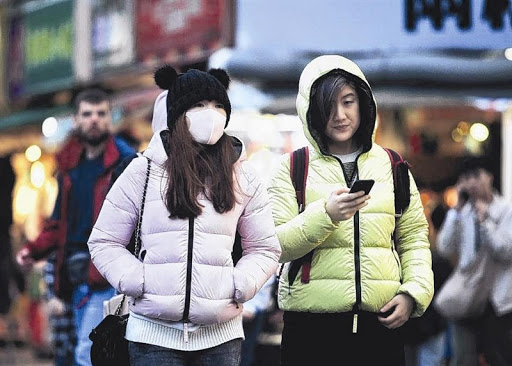

In [40]:
# An image in the Data Set(Veri Seti içerisinde bir resim)
Image.open("/content/face-mask-detection/images/maksssksksss0.png")

In [41]:
# XML format tag of the image above.(Yukarıdaki resimin XML formatındaki etiketi.)
with open('/content/face-mask-detection/annotations/maksssksksss0.xml') as f:
    contents = f.read()
    print(contents)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</

In [42]:
# TXT version of the above label in XML format(Yularıdaki XML formatında olan etiketin TXT hali)
with open('/content/labels/maksssksksss0.txt') as f:
    contents = f.read()
    print(contents)

0 0.18359375 0.337431693989071 0.05859375 0.10109289617486339
1 0.4013671875 0.3333333333333333 0.080078125 0.12021857923497267
0 0.6689453125 0.3155737704918033 0.068359375 0.13934426229508196


## Create Data For YoloV8(YoloV8 İçin Veri Oluştur)

EN
In this section, I created the training dataset for YoloV8 using the label data and image data I created.

---
TR
Bu kısımda oluşturduğumuz etiket verileri ile image verilerini kullanarak YoloV8 için eğitim veri setini oluşturdum.

In [44]:
# Names and creation of files prepared for YoloV8(YoloV8 için hazırlanan dosyaların isimleri ve oluşturulmesı)
if os.path.isfile("/content/data/"):
    print("Dosya mevcut! (There is folder!)")
else:
    os.mkdir("/content/data/")
    os.mkdir('/content/data/train')
    os.mkdir('/content/data/val')
    os.mkdir('/content/data/test')
    os.mkdir('/content/data/train/images')
    os.mkdir('/content/data/train/labels')
    os.mkdir('/content/data/test/images')
    os.mkdir('/content/data/test/labels')
    os.mkdir('/content/data/val/images')
    os.mkdir('/content/data/val/labels')

FileExistsError: ignored

In [ ]:
# Listing the names of image data together(Image verilerinin isimlerinin bir liste içerisine alınması)
metarial = []

for i in os.listdir("/content/face-mask-detection/images"):
    srt = i[:-4]
    metarial.append(srt)

In [ ]:
# Initial data of Merarial list(Merarial listesinin ilk on verileri)
metarial[0:10]

In [ ]:
# Data set creation function(Veri setini oluşturma fonksiyonu)
def preparinbdata(main_txt_file, main_img_file, train_size, test_size, val_size):

    for i in range(0,train_size):

        source_txt = main_txt_file + "/" + metarial[i] + ".txt"
        source_img = main_img_file + "/" + metarial[i] + ".png"

        mstring = metarial[i]
        train_destination_txt = "/content/data/train/labels" + "/" + metarial[i] + ".txt"
        train_destination_png = "/content/data/train/images" + "/" + metarial[i] + ".png"

        shutil.copy(source_txt, train_destination_txt)
        shutil.copy(source_img, train_destination_png)

        #metarial.remove(file_name[:-4])


    for l in range(train_size , train_size + test_size):

        source_txt = main_txt_file + "/" + metarial[l] + ".txt"
        source_img = main_img_file + "/" + metarial[l] + ".png"

        mstring = metarial[l]
        test_destination_txt = "/content/data/test/labels" + "/" + metarial[l] + ".txt"
        test_destination_png = "/content/data/test/images" + "/" + metarial[l] + ".png"

        shutil.copy(source_txt, test_destination_txt)
        shutil.copy(source_img, test_destination_png)

        #metarial.remove(file_name[:-4])


    for n in range(train_size + test_size , train_size + test_size + val_size):

        source_txt = main_txt_file + "/" + metarial[n] + ".txt"
        source_img = main_img_file + "/" + metarial[n] + ".png"

        mstring = metarial[n]
        val_destination_txt = "/content/data/val/labels" + "/" + metarial[n] + ".txt"
        val_destination_png = "/content/data/val/images" + "/" + metarial[n] + ".png"

        shutil.copy(source_txt, val_destination_txt)
        shutil.copy(source_img, val_destination_png)

        #metarial.remove(file_name[:-4])

In [ ]:
# I'm streaming data(Veri dağıtım işilemini gerçekleştiriyoruz)
preparinbdata("/content/labels", "/content/face-mask-detection/images", 603, 150, 100)

In [ ]:
# configure .yaml file to guide the model for training(Eğitim için modeli yönlendirmek üzere .yaml dosyasını yapılandırın)
%cd /content/data

yaml_text = """train: /content/data/train/images
val: /content/data/val/images

nc: 3
names: ["without_mask", "with_mask", "mask_weared_incorrect"]"""

with open("/content/data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat data/data.yaml

# YoloV8

EN
This file consists of downloading the YoloV8 library, training and detection parts.

---
TR
Bu kısımda YoloV8 kütüphanesinin indirilmesi, eğitim ve tesip aşamalarında oluşuyor.

In [ ]:
# (YoloV8 kütüphanesi kullanmak için 'ultralytics' kütüphanesi kuruyoruz)
%pip install ultralytics
import ultralytics
ultralytics.checks()

## Training(Training)

EN
I will perform the training using the data set I prepared in this section. I will do a 50-step training. If you want, you can increase this epochs

---
TR
Bu bölümde hazırladığım veri seti kullanarak eğitimi gerçekleştireceğim. 50 adımlık bir eğitim gerçekleştireceğim. Siz isterseniz adımları daha da arttırıp sonuçları gözlemleyebilirsiniz.

In [ ]:
# /content/data
if os.path.isfile("/content/Result/"):
    print("Dosya mevcut! (There is folder!)")
else:
    os.mkdir("/content/Result/")

%cd /content/Result/

# YoloV8 modeli 50 adımlık eğitimi yapıyorum(I am doing YoloV8 model 50 step training)
# data = "Path to the file with .yaml extension(Oluşturduğunum .yaml uzantılı dosyanın yolu)"
# epochs = How many steps will you train?(Kaç adımlı eğitim yapacağınız)
# imagsz = This is size of image at the training data(Eğitim verilerindeki resimlerin boyutu)
!yolo train model=yolov8n.pt data=/content/data/data.yaml epochs=50 imgsz=640

In [ ]:
# The result of my training(Yaptığım eğitim sonucu)
Image.open("/content/Result/runs/detect/train/results.png")

## Detection(Tespit etme)

EN
Tests are performed on the images in the test data set using the Best.pt file resulting from the training. At the same time, I will perform tests with real-life data.

---
TR
Eğitim sonucunda çıkan Best.pt dosyasyasını kullanarak test veri seti içerisideki resimlerin üzerinde testler yapacağım. Aynı zamanda gerçek hayattın veriler ilede testler gerçekleştireceğim.

In [ ]:

!yolo predict model=/content/Result/runs/detect/train/weights/best.pt source='/content/data/test/images'

Aşağıdaki resimler test veri setinin içerisinde bulunan resimlerin maskeli insanların tespit edilmiş halleridir.

In [ ]:
# Detection result(Tespit sonucu) - 1
Image.open('/content/Result/runs/detect/predict/maksssksksss1.png')

In [ ]:
# Detection result(Tespit sonucu) - 2
Image.open('/content/Result/runs/detect/predict/maksssksksss232.png')

In [ ]:
# Detection result(Tespit sonucu) - 3
Image.open('/content/Result/runs/detect/predict/maksssksksss677.png')

In [ ]:
# Download the real-world data(Gerçek dünya verilerini indiriyorum)
%cd /content
!wget "https://onecms-res.cloudinary.com/image/upload/s--XV7DHKzY--/c_fill,g_auto,h_468,w_830/f_auto,q_auto/people-wearing-mask-at-orchard-road-singapore-feb-3--49-.jpg?itok=GdDk1T6A"

# I check my upload and then change the name of the image I downloaded(Yüklememi konrol ediyorum ve artından indirdiğim resimin ismini değiştiriyorum)
if os.path.isfile("/content/people-wearing-mask-at-orchard-road-singapore-feb-3--49-.jpg?itok=GdDk1T6A"):
  os.rename("people-wearing-mask-at-orchard-road-singapore-feb-3--49-.jpg?itok=GdDk1T6A", "image.jpg")

In [ ]:
# Detection on real-world(Gerçek Dünya verisi üzerinde tespit)
%cd /content/Result
!yolo predict model=/content/Result/runs/detect/train/weights/best.pt source='/content/image.jpg'

In [ ]:
# Result of detection(Tespit sonucu)
Image.open('/content/Result/runs/detect/predict2/image.jpg')

In [ ]:
# Download the real-world data(Gerçek dünya verilerini indiriyorum)
%cd /content
!wget "https://cloudfront-us-east-2.images.arcpublishing.com/reuters/KPYTVDNVAZIOFDEB2JJN4BHYFU.jpg"

In [ ]:
# I check my upload and then change the name of the image I downloaded(Yüklememi konrol ediyorum ve artından indirdiğim resimin ismini değiştiriyorum)
if os.path.isfile("/content/KPYTVDNVAZIOFDEB2JJN4BHYFU.jpg"):
  os.rename("KPYTVDNVAZIOFDEB2JJN4BHYFU.jpg", "image2.jpg")

In [ ]:
# Detection on real-world(Gerçek Dünya verisi üzerinde tespit)
%cd /content/Result
!yolo predict model=/content/Result/runs/detect/train/weights/best.pt source='/content/image2.jpg'

In [ ]:
# Result of detection(Tespit sonucu)
Image.open('/content/Result/runs/detect/predict3/image2.jpg')